In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import time
%load_ext autoreload
%autoreload 2


In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval();


Using cache found in /home/marcotcr/.cache/torch/hub/pytorch_vision_v0.10.0


In [3]:
if torch.cuda.is_available():
    model.to('cuda')

In [4]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    class_names = [s.strip() for s in f.readlines()]


--2022-07-19 10:38:06--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8000::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-07-19 10:38:06 (47.6 MB/s) - ‘imagenet_classes.txt.1’ saved [10472/10472]



In [5]:
import skimage.io
import skimage.transform
from skimage import color
def transform_img_fast(path):
    img = skimage.io.imread(path)
    if len(img.shape) != 3:
        img = skimage.color.gray2rgb(img)
    if img.shape[2] == 4:
        img = color.rgba2rgb(img)
    short_egde = min(img.shape[:2])
    yy = int((img.shape[0] - short_egde) / 2)
    xx = int((img.shape[1] - short_egde) / 2)
    crop_img = img[yy: yy + short_egde, xx: xx + short_egde]
    return (skimage.transform.resize(crop_img, (299, 299)) - 0.5) * 2
def transform_img_fn_fast(paths):
    out = []
    for i, path in enumerate(paths):
        if i % 100 == 0:
            print(i)
        out.append(transform_img_fast(path))
    return np.array(out)
#     return np.array([transform_img_fast(path) for path in paths])

In [6]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [19]:
# def load_images(paths):
#     out = []
#     for path in paths:
#         input_image = Image.open(path)
#         tensor = preprocess(input_image).numpy()
#         out.append(tensor)
#     return out

In [7]:
#images = transform_img_fn_fast(['dog.jpg'])
images = transform_img_fn_fast(['nick.png'])

0


In [8]:
def predict(images):
    images = images.transpose((0, 3, 1, 2))
    input_tensor = torch.FloatTensor(images)
    if torch.cuda.is_available():
        input_tensor = input_tensor.to('cuda')
    with torch.no_grad():
        output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    return probabilities.cpu().numpy()

In [11]:
import copy
from skimage.segmentation import quickshift, mark_boundaries, slic, felzenszwalb
def ShowImageNoAxis(image, boundaries=None, save=None):
    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    if boundaries is not None:
        ax.imshow(mark_boundaries(image / 2 + 0.5, boundaries))
    else:
        ax.imshow(image / 2 + .5)
    if save is not None:
        plt.savefig(save)
    plt.show()


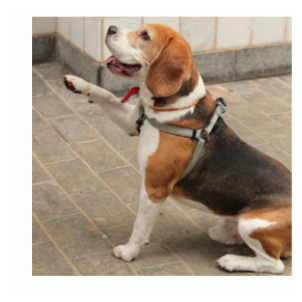

In [12]:
ShowImageNoAxis(images[0])

In [10]:
probs = predict(images)
idxs = np.argsort(-probs[0])
list(zip(probs[0][idxs[:5]], np.array(class_names)[idxs[:5]]))

[(0.94672316, 'beagle'),
 (0.023323692, 'Walker hound'),
 (0.015085177, 'English foxhound'),
 (0.00053130335, 'basenji'),
 (0.00043689235, 'basset')]

In [13]:
import anchor
import anchor.anchor_image

In [14]:
import anchor
#/home/marcotcr/datasets/openimages/train contains a lot of arbitrary images - in this case, from openimages
explainer = anchor.anchor_image.AnchorImage('/home/marcotcr/datasets/openimages/train/',
                               transform_img_fn=transform_img_fn_fast, n=5000)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [16]:
segments, exp = explainer.explain_instance(images[0], predict, threshold=0.95, batch_size=50,
                                            tau=0.20, verbose=True, min_shared_samples=200, beam_size=2)

True pred 162
Best: 13 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 0 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 7 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 54 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 54 (mean:0.0196078431, n: 51, lb:0.0000) Worst: 53 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 54 (mean:0.0198019802, n: 101, lb:0.0000) Worst: 52 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 52 (mean:0.0588235294, n: 51, lb:0.0000) Worst: 51 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 52 (mean:0.0297029703, n: 101, lb:0.0000) Worst: 50 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 52 (mean:0.0397350993, n: 151, lb:0.0000) Worst: 49 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 52 (mean:0.0298507463, n: 201, lb:0.0000) Worst: 55 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 52 (mean:0.0358565737, n: 251, lb:0.0000) Worst: 48 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 52 (mean:0.0299003322, n: 301, lb:0.0000) Worst: 47 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 47 (mean

Best: 16 (mean:0.0842572062, n: 451, lb:0.0000) Worst: 58 (mean:0.0196, n: 51, ub:0.4669) B = 0.47
Best: 16 (mean:0.0858283433, n: 501, lb:0.0000) Worst: 5 (mean:0.0196, n: 51, ub:0.4670) B = 0.47
Best: 16 (mean:0.0871143376, n: 551, lb:0.0000) Worst: 59 (mean:0.0196, n: 51, ub:0.4671) B = 0.47
Best: 16 (mean:0.0915141431, n: 601, lb:0.0000) Worst: 55 (mean:0.0196, n: 51, ub:0.4673) B = 0.47
Best: 16 (mean:0.0875576037, n: 651, lb:0.0000) Worst: 37 (mean:0.0196, n: 51, ub:0.4674) B = 0.47
Best: 16 (mean:0.0927246790, n: 701, lb:0.0000) Worst: 62 (mean:0.0196, n: 51, ub:0.4676) B = 0.47
Best: 16 (mean:0.0945406125, n: 751, lb:0.0000) Worst: 61 (mean:0.0196, n: 51, ub:0.4677) B = 0.47
Best: 16 (mean:0.0998751561, n: 801, lb:0.0000) Worst: 12 (mean:0.0196, n: 51, ub:0.4679) B = 0.47
Best: 16 (mean:0.1010575793, n: 851, lb:0.0000) Worst: 25 (mean:0.0196, n: 51, ub:0.4680) B = 0.47
Best: 16 (mean:0.1009988901, n: 901, lb:0.0000) Worst: 2 (mean:0.0196, n: 51, ub:0.4681) B = 0.47
Best: 16 (me

Best: 16 (mean:0.1046363250, n: 2351, lb:0.0375) Worst: 70 (mean:0.0099, n: 101, ub:0.3338) B = 0.30
Best: 8 (mean:0.0694077707, n: 2651, lb:0.0378) Worst: 61 (mean:0.0099, n: 101, ub:0.3339) B = 0.30
Best: 8 (mean:0.0684931507, n: 2701, lb:0.0372) Worst: 27 (mean:0.0099, n: 101, ub:0.3339) B = 0.30
Best: 8 (mean:0.0679752817, n: 2751, lb:0.0369) Worst: 74 (mean:0.0099, n: 101, ub:0.3340) B = 0.30
Best: 8 (mean:0.0678329168, n: 2801, lb:0.0371) Worst: 76 (mean:0.0099, n: 101, ub:0.3340) B = 0.30
Best: 16 (mean:0.1049562682, n: 2401, lb:0.0385) Worst: 2 (mean:0.0099, n: 101, ub:0.3341) B = 0.30
Best: 8 (mean:0.0694493160, n: 2851, lb:0.0389) Worst: 9 (mean:0.0099, n: 101, ub:0.3341) B = 0.30
Best: 8 (mean:0.0692864529, n: 2901, lb:0.0390) Worst: 3 (mean:0.0099, n: 101, ub:0.3342) B = 0.30
Best: 8 (mean:0.0691291088, n: 2951, lb:0.0391) Worst: 7 (mean:0.0099, n: 101, ub:0.3342) B = 0.30
Best: 16 (mean:0.1052631579, n: 2451, lb:0.0394) Worst: 13 (mean:0.0099, n: 101, ub:0.3343) B = 0.29
B

Best: 16 (mean:0.0965193779, n: 4051, lb:0.0448) Worst: 56 (mean:0.0348, n: 201, ub:0.2669) B = 0.22
Best: 16 (mean:0.0965618142, n: 4101, lb:0.0452) Worst: 19 (mean:0.0348, n: 201, ub:0.2669) B = 0.22
Best: 8 (mean:0.0686992675, n: 5051, lb:0.0455) Worst: 38 (mean:0.0348, n: 201, ub:0.2670) B = 0.22
Best: 8 (mean:0.0690060772, n: 5101, lb:0.0460) Worst: 51 (mean:0.0299, n: 201, ub:0.2620) B = 0.22
Best: 16 (mean:0.0970850397, n: 4151, lb:0.0460) Worst: 39 (mean:0.0299, n: 201, ub:0.2620) B = 0.22
Best: 16 (mean:0.0959295406, n: 4201, lb:0.0451) Worst: 31 (mean:0.0299, n: 201, ub:0.2621) B = 0.22
Best: 8 (mean:0.0691127936, n: 5151, lb:0.0462) Worst: 6 (mean:0.0249, n: 201, ub:0.2571) B = 0.21
Best: 16 (mean:0.0966831334, n: 4251, lb:0.0462) Worst: 67 (mean:0.0249, n: 201, ub:0.2571) B = 0.21
Best: 16 (mean:0.0960241804, n: 4301, lb:0.0458) Worst: 60 (mean:0.0249, n: 201, ub:0.2572) B = 0.21
Best: 16 (mean:0.0962997012, n: 4351, lb:0.0464) Worst: 14 (mean:0.0249, n: 201, ub:0.2572) B =

Best: 19 (mean:0.7350993377, n: 151, lb:0.4942) Worst: 121 (mean:0.5476, n: 42, ub:1.0000) B = 0.51
Best: 31 (mean:0.7166666667, n: 60, lb:0.3317) Worst: 68 (mean:0.5652, n: 46, ub:1.0000) B = 0.67
Best: 21 (mean:0.7068965517, n: 58, lb:0.3130) Worst: 110 (mean:0.6000, n: 55, ub:1.0000) B = 0.69
Best: 34 (mean:0.7049180328, n: 61, lb:0.3189) Worst: 59 (mean:0.5714, n: 49, ub:1.0000) B = 0.68
Best: 34 (mean:0.7117117117, n: 111, lb:0.4244) Worst: 83 (mean:0.6042, n: 48, ub:1.0000) B = 0.58
Best: 19 (mean:0.6965174129, n: 201, lb:0.4822) Worst: 82 (mean:0.5625, n: 48, ub:1.0000) B = 0.52
Best: 80 (mean:0.6935483871, n: 62, lb:0.3063) Worst: 13 (mean:0.6071, n: 56, ub:1.0000) B = 0.69
Best: 104 (mean:0.6904761905, n: 42, lb:0.2186) Worst: 133 (mean:0.6071, n: 56, ub:1.0000) B = 0.78
Best: 104 (mean:0.7173913043, n: 92, lb:0.3977) Worst: 41 (mean:0.6078, n: 51, ub:1.0000) B = 0.60
Best: 34 (mean:0.6894409938, n: 161, lb:0.4472) Worst: 75 (mean:0.6066, n: 61, ub:1.0000) B = 0.55
Best: 107 (

Best: 143 (mean:0.7413617886, n: 1968, lb:0.6681) Worst: 10 (mean:0.6263, n: 99, ub:0.9527) B = 0.28
Best: 143 (mean:0.7403369673, n: 2018, lb:0.6680) Worst: 72 (mean:0.6957, n: 161, ub:0.9517) B = 0.28
Best: 7 (mean:0.8424068768, n: 349, lb:0.6684) Worst: 94 (mean:0.6311, n: 103, ub:0.9513) B = 0.28
Best: 143 (mean:0.7417794971, n: 2068, lb:0.6703) Worst: 82 (mean:0.6224, n: 98, ub:0.9509) B = 0.28
Best: 143 (mean:0.7407932011, n: 2118, lb:0.6701) Worst: 139 (mean:0.6781, n: 146, ub:0.9472) B = 0.28
Best: 143 (mean:0.7412361624, n: 2168, lb:0.6714) Worst: 141 (mean:0.6330, n: 109, ub:0.9446) B = 0.27
Best: 143 (mean:0.7412082958, n: 2218, lb:0.6721) Worst: 136 (mean:0.6330, n: 109, ub:0.9447) B = 0.27
Best: 143 (mean:0.7420634921, n: 2268, lb:0.6737) Worst: 111 (mean:0.6250, n: 104, ub:0.9442) B = 0.27
Best: 143 (mean:0.7415875755, n: 2318, lb:0.6740) Worst: 44 (mean:0.6250, n: 104, ub:0.9443) B = 0.27
Best: 143 (mean:0.7423986486, n: 2368, lb:0.6755) Worst: 105 (mean:0.6818, n: 154, 

Best: 143 (mean:0.7365371506, n: 5868, lb:0.6934) Worst: 105 (mean:0.6716, n: 204, ub:0.9031) B = 0.21
Best: 7 (mean:0.8416833667, n: 499, lb:0.6936) Worst: 124 (mean:0.6700, n: 203, ub:0.9021) B = 0.21
Best: 143 (mean:0.7367353836, n: 5918, lb:0.6937) Worst: 79 (mean:0.6420, n: 162, ub:0.9019) B = 0.21
Best: 143 (mean:0.7359249330, n: 5968, lb:0.6931) Worst: 45 (mean:0.6309, n: 149, ub:0.9019) B = 0.21
Best: 143 (mean:0.7369557993, n: 6018, lb:0.6943) Worst: 78 (mean:0.6346, n: 156, ub:0.8995) B = 0.21
Best: 143 (mean:0.7371456823, n: 6068, lb:0.6947) Worst: 37 (mean:0.7071, n: 297, ub:0.8991) B = 0.20
Best: 143 (mean:0.7381497221, n: 6118, lb:0.6958) Worst: 86 (mean:0.7238, n: 362, ub:0.8977) B = 0.20
Best: 143 (mean:0.7381647211, n: 6168, lb:0.6960) Worst: 136 (mean:0.6352, n: 159, ub:0.8977) B = 0.20
Best: 143 (mean:0.7380186555, n: 6218, lb:0.6960) Worst: 136 (mean:0.6794, n: 209, ub:0.9084) B = 0.21
Best of size  4 :
143 0.7388321633694959 0.7157840914684923 0.7618802352704994
(4

Best: 87 (mean:0.8597168597, n: 1554, lb:0.7778) Worst: 120 (mean:0.7923, n: 207, ub:1.0000) B = 0.22
Best: 93 (mean:0.8585607940, n: 1612, lb:0.7781) Worst: 59 (mean:0.8048, n: 251, ub:1.0000) B = 0.22
Best: 93 (mean:0.8586040915, n: 1662, lb:0.7793) Worst: 65 (mean:0.8271, n: 214, ub:1.0000) B = 0.22
Best: 87 (mean:0.8584788030, n: 1604, lb:0.7777) Worst: 65 (mean:0.8106, n: 264, ub:1.0000) B = 0.22
Best: 87 (mean:0.8585247884, n: 1654, lb:0.7790) Worst: 141 (mean:0.8313, n: 160, ub:1.0000) B = 0.22
Best: 82 (mean:0.8584070796, n: 113, lb:0.5540) Worst: 141 (mean:0.8000, n: 210, ub:1.0000) B = 0.45
Best: 12 (mean:0.8584070796, n: 113, lb:0.5539) Worst: 17 (mean:0.7818, n: 220, ub:1.0000) B = 0.45
Best: 80 (mean:0.8580645161, n: 155, lb:0.5980) Worst: 82 (mean:0.8098, n: 163, ub:1.0000) B = 0.40
Best: 102 (mean:0.8571428571, n: 126, lb:0.5686) Worst: 12 (mean:0.8282, n: 163, ub:1.0000) B = 0.43
Best: 11 (mean:0.8571428571, n: 210, lb:0.6335) Worst: 12 (mean:0.7981, n: 213, ub:1.0000) 

Best: 33 (mean:0.8601941748, n: 515, lb:0.7149) Worst: 37 (mean:0.8171, n: 164, ub:1.0000) B = 0.29
Best: 33 (mean:0.8566371681, n: 565, lb:0.7179) Worst: 62 (mean:0.8424, n: 203, ub:1.0000) B = 0.28
Best: 33 (mean:0.8504065041, n: 615, lb:0.7174) Worst: 62 (mean:0.8103, n: 253, ub:1.0000) B = 0.28
Best: 33 (mean:0.8541353383, n: 665, lb:0.7262) Worst: 62 (mean:0.8218, n: 303, ub:1.0000) B = 0.27
Best: 33 (mean:0.8531468531, n: 715, lb:0.7297) Worst: 139 (mean:0.8438, n: 160, ub:1.0000) B = 0.27
Best: 33 (mean:0.8509803922, n: 765, lb:0.7316) Worst: 139 (mean:0.8143, n: 210, ub:1.0000) B = 0.27
Best: 33 (mean:0.8515337423, n: 815, lb:0.7359) Worst: 139 (mean:0.8154, n: 260, ub:1.0000) B = 0.26
Best: 33 (mean:0.8462427746, n: 865, lb:0.7340) Worst: 139 (mean:0.8161, n: 310, ub:1.0000) B = 0.27
Best: 33 (mean:0.8459016393, n: 915, lb:0.7367) Worst: 138 (mean:0.8440, n: 109, ub:1.0000) B = 0.26
Best: 93 (mean:0.8449084937, n: 4262, lb:0.7943) Worst: 138 (mean:0.7987, n: 159, ub:1.0000) B 

Best: 55 (mean:0.9346153846, n: 260, lb:0.7351) Worst: 62 (mean:0.8372, n: 172, ub:1.0000) B = 0.26
Best: 73 (mean:0.9340974212, n: 349, lb:0.7618) Worst: 62 (mean:0.8423, n: 222, ub:1.0000) B = 0.24
Best: 38 (mean:0.9340277778, n: 288, lb:0.7442) Worst: 62 (mean:0.8456, n: 272, ub:1.0000) B = 0.26
Best: 19 (mean:0.9333333333, n: 75, lb:0.5613) Worst: 62 (mean:0.8509, n: 322, ub:1.0000) B = 0.44
Best: 40 (mean:0.9333333333, n: 510, lb:0.7906) Worst: 62 (mean:0.8522, n: 372, ub:1.0000) B = 0.21
Best: 7 (mean:0.9470338983, n: 472, lb:0.7986) Worst: 62 (mean:0.8626, n: 422, ub:1.0000) B = 0.20
Best of size  6 :
40 0.9375 0.8603909983038642 0.96875
(1, 4, 8, 16, 19, 31) mean = 0.94 lb = 0.86 ub = 0.97 coverage: 0.01 n: 560
7 0.946360153256705 0.8664938022527592 1
(1, 4, 8, 16, 31, 34) mean = 0.95 lb = 0.88 ub = 0.97 coverage: 0.01 n: 672
Best: 129 (mean:1.0000000000, n: 48, lb:0.5938) Worst: 33 (mean:0.8448, n: 58, ub:1.0000) B = 0.41
Best: 119 (mean:1.0000000000, n: 46, lb:0.5745) Worst: 

Best of size  7 :
8 0.9722991689750693 0.92427990518249 1
(1, 4, 8, 15, 16, 31, 34) mean = 0.97 lb = 0.92 ub = 1.00 coverage: 0.01 n: 361
Found eligible anchor  (1, 4, 8, 15, 16, 31, 34) Coverage: 0.006 Is best? True
72 0.9951456310679612 0.9315780788960518 1
(1, 3, 4, 8, 16, 31, 34) mean = 1.00 lb = 0.93 ub = 1.00 coverage: 0.01 n: 206
Found eligible anchor  (1, 3, 4, 8, 16, 31, 34) Coverage: 0.0062 Is best? True


In [17]:
exp

[(16, '', 0.09582260938428035, [], 0),
 (8, '', 0.34942084942084944, [], 0),
 (4, '', 0.6127819548872181, [], 0),
 (31, '', 0.7388321633694959, [], 0),
 (1, '', 0.9175654853620955, [], 0),
 (34, '', 0.9479166666666666, [], 0),
 (3, '', 0.9951456310679612, [], 0)]

Anchor for prediction  beagle confidence 0.9951456310679612


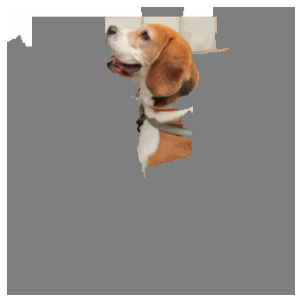

Counter Examples:


In [18]:
def show_exp(segments, exp, image, explainer):
    mask = np.ones(segments.shape).astype(bool)
    temp = copy.deepcopy(image)
    temp_img = copy.deepcopy(temp)
#     temp.img = temp.fudged_image.copy()
    temp[:] = 0
    # for x in exp_greedy[:3]:
    #     x = (x, x)
    for x in exp:
        temp[segments == x[0]] = temp_img[segments==x[0]]
    # temp.img[mask] = np.random.random(mask.nonzero()[0].shape[0] * 3).reshape(mask.nonzero()[0].shape[0], 3)
    print ('Anchor for prediction ', class_names[predict(np.expand_dims(image, 0))[0].argmax()], 'confidence', exp[-1][2])
    ShowImageNoAxis(temp)
    print('Counter Examples:')
    for e in exp[-1][3]:
        data = e[:-1]
        temp = explainer.dummys[e[-1]].copy()
        for x in data.nonzero()[0]:
            temp[segments == x] = image[segments == x]
        ShowImageNoAxis(temp)
        print('Prediction = ', names[predict_fn(np.expand_dims(temp, 0))[0].argmax()])
show_exp(segments, exp, images[0], explainer)

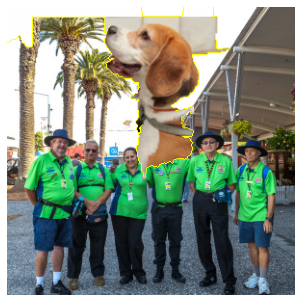

beagle 0.8532552


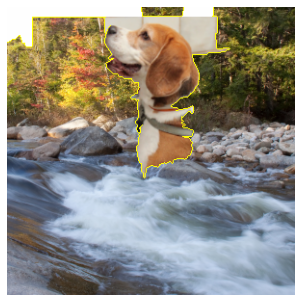

beagle 0.95835763


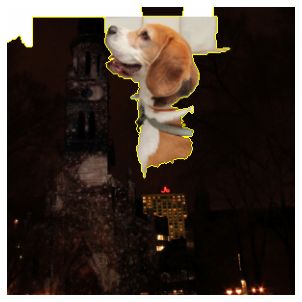

beagle 0.8676405


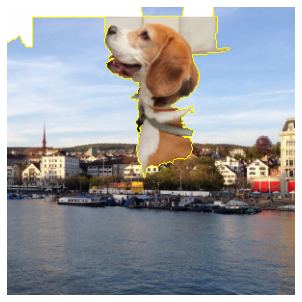

beagle 0.7541815


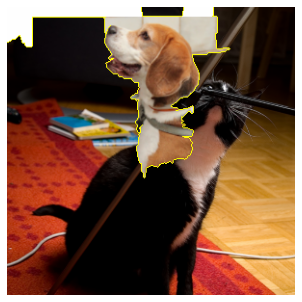

beagle 0.83341825


In [19]:
N = 5
chosen = np.random.choice(len(explainer.dummys), N)
imgs = []
masks = []
for c in chosen:
    temp = copy.deepcopy(explainer.dummys[c])
    mask = np.zeros(segments.shape).astype(bool)
    for f in exp:
        f = f[0]
        mask[segments == f] = 1
    temp[mask] = images[0][mask].copy()
    imgs.append(temp)
    masks.append(mask)
preds = predict(np.array(imgs))
for i, p in zip(imgs, preds):
#     if p.max() < 0.9:
#         continue
    ShowImageNoAxis(i, mask, '/tmp/nickz.png')
    print(class_names[p.argmax()], p.max())